# Step 0: Import necessary packages

In [8]:
import requests
import matplotlib.pyplot as plt
import numpy as np
import os
import psutil

from astropy.io import fits


# Step 1: Search for and store BepiColombo data products

In [9]:
response = requests.get('https://pds.nasa.gov/api/search/1/products?q=((pds:Science_Facets.pds:wavelength_range eq "Visible") '
                        'and not (ops:Harvest_Info.ops:node_name eq "PDS_SBN") '
                        'and (pds:Investigation_Area.pds:name eq "BepiColombo") '
                        'and (pds:Header.pds:parsing_standard_id eq "FITS 3.0")'
                        'and (pds:Time_Coordinates.pds:start_date_time gt "2022-04-30T00:00:00Z")'
                        '  )&start=0&limit=3000')

resp_data = response.json()['data']


In [16]:
print('debug')

pydev debugger: warning: trying to add breakpoint to file that does not exist: /Users/levijr/PycharmProjects/search-api-notebook/notebooks/img/messenger_mdis.ipynb (will have no effect)
pydev debugger: warning: trying to add breakpoint to file that does not exist: /Users/levijr/PycharmProjects/search-api-notebook/notebooks/img/messenger_mdis.ipynb (will have no effect)


debug


### Store image URLS in a list format to load for visualization

In [10]:
urls = []
for prod in resp_data:
    try:
        urls.append([prod['properties']['ops:Data_File_Info.ops:file_ref'][0]])
    except KeyError:
        continue

# Step 2: Tiling of image data
Specify the page you would like to see with the page parameter. Each page displays 48 image products. The current time query is viewing BC's mercury flyby on the 23rd of June 2022.

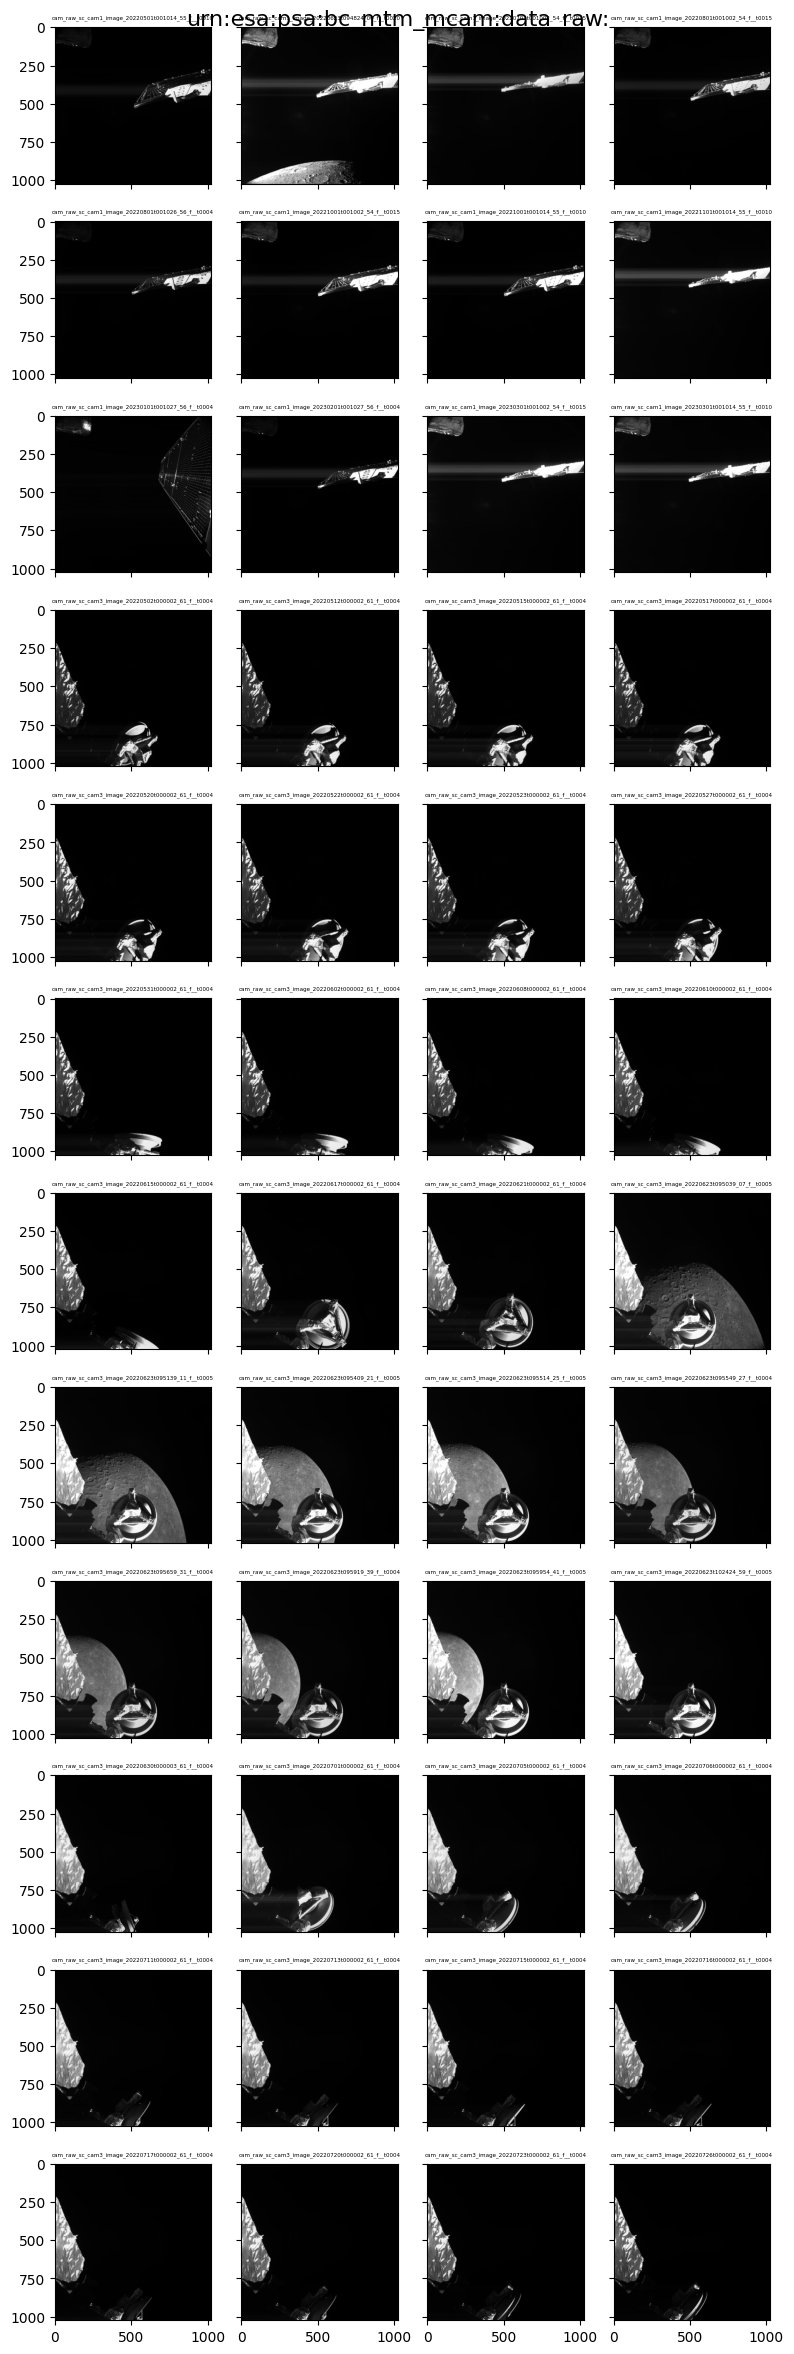

In [11]:
page = 1

fig, axs = plt.subplots(12,4 , figsize=(8, 24))

size = 4*12
mem_vals = []

for i, image_path in enumerate(urls[size*(page-1):size*page]):
    response = requests.get(image_path[0])
    with fits.open(image_path[0], memmap=True) as hdul:
        image_data = hdul[1].data
    row, col = i // 4, i % 4
    axs[row, col].imshow(image_data, cmap='gray')  # You can change the colormap as needed
    axs[row, col].set_title(resp_data[i]['properties']['lid'][0][33:], fontsize = 4) # include the full lidvid

    #Monitor memory
    process = psutil.Process(os.getpid())
    mem_usage = process.memory_info().rss / 1024 ** 2
    mem_vals.append(mem_usage)
#hdul.close()
#clearing memory?
#find a way to monitor memory
#look at open options in the fits.open library
#image_data[0::10] - but better if I can do it at the fits.open
#fix temporal order
#take the last column of the lidvid

for ax in axs.flat:
    ax.label_outer()

plt.suptitle('urn:esa:psa:bc_mtm_mcam:data_raw:', fontsize=16,y=1.02)

plt.tight_layout()
plt.show()


## Plot memory usage

/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

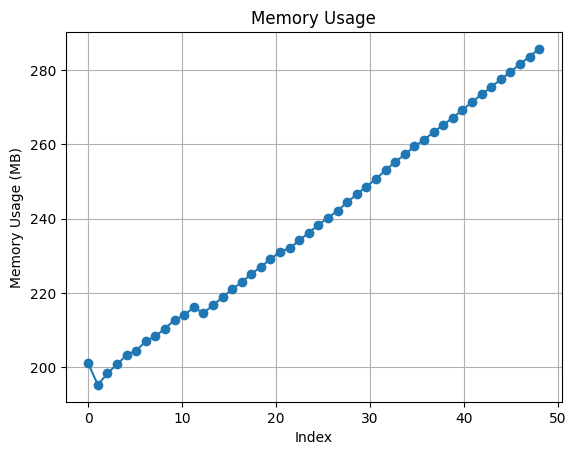

In [12]:
time = np.linspace(0, len(mem_vals),len(mem_vals))

plt.plot(time, mem_vals, marker='o')
plt.xlabel('Index')
plt.ylabel('Memory Usage (MB)')
plt.title('Memory Usage')
plt.grid(True)
plt.show()